# (2) MODELOS
Los contenidos de este notebook son los siguientes:
- 2.1 - Convertir TIF a JPEG
- 2.2 - RF y SVM en RGB
- 2.3 - RF y SVM en escala de grises
- 2.4 - CNN en datos RGB
- 2.5 - Transfer Learning con ResNet50
- 2.6 - Tunear hiperparámetros (v.1)
- 2.7 - Tunear hiperparámetros (v.2)

### (2.1) - Convertir TIF A JPEG

In [40]:
import os
import numpy as np
import rasterio
from rasterio.plot import reshape_as_image
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50


def convert_tiff_to_jpeg(input_folder, output_folder):
    # Verificar si la carpeta de salida existe, si no, crearla
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    problematic_files = []
    
    # Recorrer todos los archivos en la carpeta de entrada
    for filename in os.listdir(input_folder):
        # Comprobar si el archivo es un TIFF
        if filename.lower().endswith('.tif') or filename.lower().endswith('.tiff'):
            tiff_path = os.path.join(input_folder, filename)
            jpeg_path = os.path.join(output_folder, os.path.splitext(filename)[0] + '.jpg')
            
            try:
                # Abrir el archivo TIFF usando rasterio
                with rasterio.open(tiff_path) as src:
                    # Leer los datos del archivo TIFF
                    data = src.read()
                    
                    # Reformatear y escalar los datos para convertirlos en imagen
                    image_data = reshape_as_image(data)
                    
                    # Normalizar los datos al rango de 0 a 255
                    image_data = ((image_data - image_data.min()) / (image_data.max() - image_data.min()) * 255).astype(np.uint8)
                    
                    # Si la imagen tiene más de 3 bandas, usar solo las primeras 3
                    if image_data.shape[2] > 3:
                        image_data = image_data[:, :, :3]
                    
                    # Si la imagen es de una sola banda, convertirla a RGB
                    if image_data.shape[2] == 1:
                        image_data = np.repeat(image_data, 3, axis=2)
                    
                    # Crear una imagen usando PIL y guardarla en formato JPEG
                    img = Image.fromarray(image_data)
                    img.save(jpeg_path, 'JPEG', quality=85)
                
                print(f"Converted {filename} to JPEG")
            
            except Exception as e:
                # Guardar los archivos problemáticos que no se pudieron convertir
                problematic_files.append((filename, str(e)))
    
    # Mostrar los archivos que no se pudieron convertir, si los hay
    if problematic_files:
        print("\nThe following files could not be converted:")
        for file, error in problematic_files:
            print(f"- {file}: {error}")

def main():
    # Convertir los archivos TIFF a JPEG para las carpetas de deforestación y no deforestación
    convert_tiff_to_jpeg('nodeforestation', 'nodeforestation_jpeg')
    convert_tiff_to_jpeg('yesdeforestation', 'yesdeforestation_jpeg')

if __name__ == "__main__":
    main()

Converted nodeforestation_0_132.tif to JPEG
Converted deforestation_0_570.tif to JPEG
Converted deforestation_0_583.tif to JPEG
Converted deforestation_0_523.tif to JPEG
Converted nodeforestation_0_37.tif to JPEG
Converted deforestation_0_751.tif to JPEG
Converted deforestation_0_741.tif to JPEG
Converted deforestation_0_834.tif to JPEG
Converted nodeforestation_0_51.tif to JPEG
Converted deforestation_0_900.tif to JPEG


/tmp/ipykernel_7832/1834468310.py:27: RuntimeWarning: invalid value encountered in cast
  image_data = ((image_data - image_data.min()) / (image_data.max() - image_data.min()) * 255).astype(np.uint8)


Converted nodeforestation_0_223.tif to JPEG
Converted deforestation_0_810.tif to JPEG
Converted nodeforestation_0_45.tif to JPEG
Converted nodeforestation_0_41.tif to JPEG
Converted nodeforestation_0_147.tif to JPEG
Converted nodeforestation_0_204.tif to JPEG
Converted deforestation_0_593.tif to JPEG
Converted deforestation_0_643.tif to JPEG
Converted deforestation_0_757.tif to JPEG
Converted nodeforestation_0_83.tif to JPEG
Converted nodeforestation_0_122.tif to JPEG
Converted nodeforestation_0_93.tif to JPEG
Converted nodeforestation_0_189.tif to JPEG
Converted deforestation_0_606.tif to JPEG
Converted deforestation_0_735.tif to JPEG
Converted nodeforestation_0_232.tif to JPEG
Converted deforestation_0_633.tif to JPEG
Converted deforestation_0_713.tif to JPEG
Converted nodeforestation_0_111.tif to JPEG
Converted deforestation_0_628.tif to JPEG
Converted deforestation_0_540.tif to JPEG
Converted nodeforestation_0_148.tif to JPEG
Converted nodeforestation_0_18.tif to JPEG
Converted nod

### (2.2) - RF y SVM en datos RGB

SVM Results (Color):
Accuracy: 0.6022
              precision    recall  f1-score   support

           0       0.60      0.91      0.72       103
           1       0.62      0.19      0.29        78

    accuracy                           0.60       181
   macro avg       0.61      0.55      0.51       181
weighted avg       0.61      0.60      0.54       181


Random Forest Results (Color):
Accuracy: 0.6796
              precision    recall  f1-score   support

           0       0.67      0.84      0.75       103
           1       0.69      0.46      0.55        78

    accuracy                           0.68       181
   macro avg       0.68      0.65      0.65       181
weighted avg       0.68      0.68      0.67       181



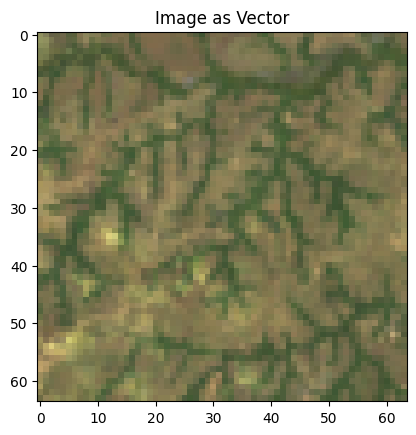

Vector de la imagen (normalizado):
[0.56862745 0.56862745 0.37647059 ... 0.36078431 0.39215686 0.25882353]
El vector ha sido guardado en vector_imagen.txt
El vector de la imagen es:
[0.56862745 0.56862745 0.37647059 ... 0.36078431 0.39215686 0.25882353]


In [2]:
# Función para cargar y preprocesar imágenes en color
def load_and_preprocess_images_color(folder_path, label):
    images = []  # Lista para almacenar las imágenes
    labels = []  # Lista para almacenar las etiquetas
    # Recorrer los archivos en la carpeta dada
    for filename in os.listdir(folder_path):
        # Verificar si el archivo es una imagen JPEG
        if filename.lower().endswith(('.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path).convert('RGB')  # Convertir la imagen a RGB (color)
            img = img.resize((64, 64))  # Redimensionar la imagen para asegurar consistencia
            img_array = np.array(img).flatten() / 255.0  # Normalizar los valores de los píxeles entre 0 y 1
            images.append(img_array)  # Añadir la imagen a la lista
            labels.append(label)  # Añadir la etiqueta correspondiente (deforestación o no)
    return images, labels  # Devolver las imágenes y las etiquetas

# Preparar los datos usando las imágenes en color
def prepare_data_color(no_deforestation_folder, yes_deforestation_folder):
    # Cargar imágenes de las carpetas de no deforestación y deforestación
    X_no, y_no = load_and_preprocess_images_color(no_deforestation_folder, 0)
    X_yes, y_yes = load_and_preprocess_images_color(yes_deforestation_folder, 1)
    
    # Combinar las imágenes y etiquetas en un solo conjunto
    X = np.vstack((X_no, X_yes))
    y = np.hstack((y_no, y_yes))
    
    return X, y  # Devolver los datos combinados

# Función para imprimir la imagen como un vector para añadir al anexo
def print_image_as_vector(img_path):
    img = Image.open(img_path).convert('RGB').resize((64, 64))  # Cargar y redimensionar la imagen
    img_array = np.array(img).flatten() / 255.0  # Convertir la imagen a un vector y normalizar
    
    # Mostrar la imagen original
    plt.imshow(img)  
    plt.title("Image as Vector")
    plt.show()  # Mostrar la imagen en pantalla
    
    # Imprimir el vector (valores normalizados de los píxeles)
    print("Vector de la imagen (normalizado):")
    print(img_array)  # Mostrar el vector en la consola
    
    return img_array  # Devolver la imagen en forma de vector

# Función para guardar el vector de la imagen en un archivo de texto
def save_image_vector_to_file(vector, output_file):
    with open(output_file, 'w') as f:
        for value in vector:
            f.write(f"{value}\n")
    print(f"El vector ha sido guardado en {output_file}")

# Función principal para cargar datos, entrenar modelos y guardar la imagen como vector
def main():
    # Preparar los datos con imágenes en color
    X, y = prepare_data_color('nodeforestation_jpeg', 'yesdeforestation_jpeg')
    
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Aplicar PCA para la reducción de dimensionalidad (retener 95% de la varianza)
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Normalizar los datos
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_pca)
    X_test_scaled = scaler.transform(X_test_pca)
    
    # Entrenar y evaluar el modelo SVM
    svm_clf = SVC(kernel='rbf', random_state=42)
    svm_clf.fit(X_train_scaled, y_train)
    svm_pred = svm_clf.predict(X_test_scaled)
    print("SVM Results (Color):")
    print(f"Accuracy: {accuracy_score(y_test, svm_pred):.4f}")
    print(classification_report(y_test, svm_pred))
    
    # Entrenar y evaluar el modelo Random Forest
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_clf.fit(X_train_scaled, y_train)
    rf_pred = rf_clf.predict(X_test_scaled)
    print("\nRandom Forest Results (Color):")
    print(f"Accuracy: {accuracy_score(y_test, rf_pred):.4f}")
    print(classification_report(y_test, rf_pred))
    
    # Mostrar una imagen como vector y guardar el vector en un archivo de texto
    vector_image = print_image_as_vector(os.path.join('yesdeforestation_jpeg', os.listdir('yesdeforestation_jpeg')[0]))
    save_image_vector_to_file(vector_image, "vector_imagen.txt")
    
    return vector_image  

# Ejecutar el código
vector_image = main()

# Mostrar el vector retornado
print("El vector de la imagen es:")
print(vector_image)

### (2.3) - RF y SVM en datos RGB con escala de grises

In [24]:
# Función para cargar y preprocesar imágenes en escala de grises
def load_and_preprocess_images(folder_path, label):
    images = []  # Lista para almacenar las imágenes
    labels = []  # Lista para almacenar las etiquetas
    # Recorrer todos los archivos en la carpeta
    for filename in os.listdir(folder_path):
        # Verificar si el archivo es una imagen con extensión .jpg o .jpeg
        if filename.lower().endswith(('.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path).convert('L')  # Convertir a escala de grises
            img = img.resize((64, 64))  # Redimensionar la imagen para mantener consistencia
            img_array = np.array(img).flatten() / 255.0  # Normalizar los valores de los píxeles entre 0 y 1
            images.append(img_array)  # Añadir la imagen a la lista
            labels.append(label)  # Añadir la etiqueta correspondiente (deforestación o no)
    return images, labels  # Devolver las imágenes y sus etiquetas

# Función para preparar los datos de deforestación y no deforestación
def prepare_data(no_deforestation_folder, yes_deforestation_folder):
    # Cargar imágenes de las carpetas de no deforestación y deforestación
    X_no, y_no = load_and_preprocess_images(no_deforestation_folder, 0)
    X_yes, y_yes = load_and_preprocess_images(yes_deforestation_folder, 1)
    
    # Combinar las imágenes y etiquetas en un solo conjunto
    X = np.vstack((X_no, X_yes))
    y = np.hstack((y_no, y_yes))
    
    return X, y  # Devolver los datos combinados

# Función principal
def main():
    # Preparar los datos
    X, y = prepare_data('nodeforestation_jpeg', 'yesdeforestation_jpeg')
    
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Aplicar PCA para la reducción de dimensionalidad (retener el 95% de la varianza)
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Normalizar los datos
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_pca)
    X_test_scaled = scaler.transform(X_test_pca)
    
    # Entrenar y evaluar el modelo SVM
    svm_clf = SVC(kernel='rbf', random_state=42)
    svm_clf.fit(X_train_scaled, y_train)
    svm_pred = svm_clf.predict(X_test_scaled)
    svm_accuracy = accuracy_score(y_test, svm_pred)
    print("SVM Results:")  # Imprimir los resultados de SVM
    print(f"Accuracy: {svm_accuracy:.4f}")
    print(classification_report(y_test, svm_pred))
    
    # Entrenar y evaluar el modelo Random Forest
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_clf.fit(X_train_scaled, y_train)
    rf_pred = rf_clf.predict(X_test_scaled)
    rf_accuracy = accuracy_score(y_test, rf_pred)
    print("\nRandom Forest Results:")  # Imprimir los resultados de Random Forest
    print(f"Accuracy: {rf_accuracy:.4f}")
    print(classification_report(y_test, rf_pred))

    # Mostrar los hiperparámetros del modelo SVM después de entrenarlo
    print("SVM Hyperparameters:")
    for param, value in svm_clf.get_params().items():
        print(f"{param}: {value}")

    # Mostrar los hiperparámetros del modelo Random Forest después de entrenarlo
    print("\nRandom Forest Hyperparameters:")
    for param, value in rf_clf.get_params().items():
        print(f"{param}: {value}")

if __name__ == "__main__":
    main()  # Ejecutar el código principal


SVM Results:
Accuracy: 0.6022
              precision    recall  f1-score   support

           0       0.60      0.90      0.72       103
           1       0.62      0.21      0.31        78

    accuracy                           0.60       181
   macro avg       0.61      0.55      0.51       181
weighted avg       0.61      0.60      0.54       181


Random Forest Results:
Accuracy: 0.6464
              precision    recall  f1-score   support

           0       0.65      0.83      0.73       103
           1       0.65      0.40      0.49        78

    accuracy                           0.65       181
   macro avg       0.65      0.62      0.61       181
weighted avg       0.65      0.65      0.63       181

SVM Hyperparameters:
C: 1.0
break_ties: False
cache_size: 200
class_weight: None
coef0: 0.0
decision_function_shape: ovr
degree: 3
gamma: scale
kernel: rbf
max_iter: -1
probability: False
random_state: 42
shrinking: True
tol: 0.001
verbose: False

Random Forest Hyperparamete

### (2.4) - CNN en datos RGB

In [2]:
# Función para cargar y preprocesar imágenes
def load_and_preprocess_images(folder_path, label, target_size=(64, 64)):
    images = []  # Lista para almacenar las imágenes
    labels = []  # Lista para almacenar las etiquetas
    # Recorrer los archivos en la carpeta dada
    for filename in os.listdir(folder_path):
        # Verificar si el archivo es una imagen JPEG
        if filename.lower().endswith(('.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path).convert('RGB')  # Convertir a formato RGB
            img = img.resize(target_size)  # Redimensionar la imagen
            img_array = np.array(img) / 255.0  # Normalizar los valores de los píxeles entre 0 y 1
            images.append(img_array)  # Añadir la imagen a la lista
            labels.append(label)  # Añadir la etiqueta correspondiente
    return images, labels  # Devolver las imágenes y etiquetas

# Función para preparar los datos de deforestación y no deforestación
def prepare_data(no_deforestation_folder, yes_deforestation_folder, target_size=(64, 64)):
    # Cargar imágenes de las carpetas de no deforestación y deforestación
    X_no, y_no = load_and_preprocess_images(no_deforestation_folder, 0, target_size)
    X_yes, y_yes = load_and_preprocess_images(yes_deforestation_folder, 1, target_size)
    
    # Combinar las imágenes y etiquetas en un solo conjunto
    X = np.array(X_no + X_yes)
    y = np.array(y_no + y_yes)
    
    return X, y  # Devolver los datos combinados

# Función para crear el modelo de red neuronal convolucional (CNN)
def create_cnn_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),  # Capa convolucional con 32 filtros
        layers.MaxPooling2D((2, 2)),  # Capa de MaxPooling
        layers.Conv2D(64, (3, 3), activation='relu'),  # Segunda capa convolucional con 64 filtros
        layers.MaxPooling2D((2, 2)),  # Segunda capa de MaxPooling
        layers.Conv2D(64, (3, 3), activation='relu'),  # Tercera capa convolucional
        layers.Flatten(),  # Aplanar la salida
        layers.Dense(64, activation='relu'),  # Capa densa con 64 neuronas
        layers.Dense(1, activation='sigmoid')  # Capa de salida con activación sigmoide para clasificación binaria
    ])
    
    # Compilar el modelo con el optimizador Adam y función de pérdida binaria
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model  # Devolver el modelo creado

# Función principal
def main():
    # Preparar los datos
    X, y = prepare_data('nodeforestation_jpeg', 'yesdeforestation_jpeg')
    
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Crear y entrenar el modelo CNN
    model = create_cnn_model(X_train.shape[1:])
    history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)
    
    # Evaluar el modelo
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print(f'\nTest accuracy: {test_acc:.4f}')  # Imprimir la precisión en el conjunto de prueba

if __name__ == "__main__":
    main()  # Ejecutar el código principal


Epoch 1/10


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.5123 - loss: 0.6950 - val_accuracy: 0.6138 - val_loss: 0.6786
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.5719 - loss: 0.6823 - val_accuracy: 0.5655 - val_loss: 0.6591
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.5402 - loss: 0.6738 - val_accuracy: 0.6069 - val_loss: 0.6426
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.5866 - loss: 0.6585 - val_accuracy: 0.6207 - val_loss: 0.6310
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.6104 - loss: 0.6525 - val_accuracy: 0.6345 - val_loss: 0.6139
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.6517 - loss: 0.6246 - val_accuracy: 0.6414 - val_loss: 0.6452
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.6147 - loss: 0.6266 - val_accuracy: 0.6069 - val_loss: 0.6234
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.6419 - loss: 0.6377 - val_accuracy: 0.6069 - val_loss: 0.

### (2.5) - Transfer Learning con ResNet50

In [3]:
def load_and_preprocess_images(folder_path, label, target_size=(224, 224)):
    images = []  # Lista para almacenar las imágenes
    labels = []  # Lista para almacenar las etiquetas
    # Recorrer todos los archivos en la carpeta proporcionada
    for filename in os.listdir(folder_path):
        # Verificar si el archivo es una imagen con extensión .jpg o .jpeg
        if filename.lower().endswith(('.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path).convert('RGB')  # Convertir la imagen a RGB
            img = img.resize(target_size)  # Redimensionar la imagen a la medida objetivo
            img_array = np.array(img)  # Convertir la imagen a una matriz numpy
            images.append(img_array)  # Añadir la imagen procesada a la lista
            labels.append(label)  # Añadir la etiqueta correspondiente a la lista
    return images, labels  # Devolver las imágenes y etiquetas

def prepare_data(no_deforestation_folder, yes_deforestation_folder, target_size=(224, 224)):
    # Cargar y preprocesar imágenes de las carpetas de no deforestación y deforestación
    X_no, y_no = load_and_preprocess_images(no_deforestation_folder, 0, target_size)
    X_yes, y_yes = load_and_preprocess_images(yes_deforestation_folder, 1, target_size)
    
    # Combinar las imágenes y etiquetas en un solo conjunto
    X = np.array(X_no + X_yes)
    y = np.array(y_no + y_yes)
    
    return X, y  # Devolver los datos combinados

def create_transfer_learning_model():
    # Crear el modelo de transferencia de aprendizaje usando ResNet50
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Congelar las capas del modelo base
    
    # Añadir capas adicionales al modelo
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),  # Aplicar GlobalAveragePooling a la salida del modelo base
        layers.Dense(256, activation='relu'),  # Añadir capa densa de 256 neuronas con activación ReLU
        layers.Dropout(0.5),  # Añadir Dropout para evitar el sobreajuste
        layers.Dense(1, activation='sigmoid')  # Capa de salida con activación sigmoide para clasificación binaria
    ])
    
    # Compilar el modelo con Adam y pérdida binaria
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model  # Devolver el modelo creado

def main():
    # Preparar los datos
    X, y = prepare_data('nodeforestation_jpeg', 'yesdeforestation_jpeg')
    
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Crear y entrenar el modelo de transferencia de aprendizaje
    model = create_transfer_learning_model()
    history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)
    
    # Evaluar el modelo
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print(f'\nTest accuracy: {test_acc:.4f}')  # Imprimir la precisión en el conjunto de prueba

if __name__ == "__main__":
    main()  # Ejecutar la función principal


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10


2024-09-26 20:32:50.311512: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 86704128 exceeds 10% of free system memory.
2024-09-26 20:32:55.258635: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2024-09-26 20:32:55.334848: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 106463232 exceeds 10% of free system memory.
2024-09-26 20:32:55.364125: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2024-09-26 20:32:55.469195: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.


18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5121 - loss: 1.1463 - val_accuracy: 0.5862 - val_loss: 0.7705
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6669 - loss: 0.6248 - val_accuracy: 0.6276 - val_loss: 0.6492
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7238 - loss: 0.5288 - val_accuracy: 0.6759 - val_loss: 0.5920
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8122 - loss: 0.4563 - val_accuracy: 0.7310 - val_loss: 0.5653
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8005 - loss: 0.4282 - val_accuracy: 0.7103 - val_loss: 0.5771
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7704 - loss: 0.4278 - val_accuracy: 0.7034 - val_loss: 0.5908
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7684 - loss: 0.4330 - val_accuracy: 0.6690 - val_loss: 0.6046
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8070 - loss: 0.4161 - val_accuracy: 0.7310 - val_loss: 0.5851
Epo

### (2.6) - Tunear hiperparámetros (v.1)

In [17]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
import logging

# Configurar logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_and_preprocess_images(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(img_path).convert('L')  # Convertir a escala de grises
                img = img.resize((64, 64))  # Redimensionar para consistencia
                img_array = np.array(img).flatten() / 255.0  # Normalizar a [0, 1]
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                logging.warning(f"Failed to process image {img_path}: {e}")
        else:
            logging.info(f"Skipping file {filename}, not a valid image.")
    return images, labels

def prepare_data(no_deforestation_folder, yes_deforestation_folder):
    logging.info("Loading no deforestation images...")
    X_no, y_no = load_and_preprocess_images(no_deforestation_folder, 0)
    logging.info(f"Loaded {len(X_no)} no deforestation images.")
    
    logging.info("Loading deforestation images...")
    X_yes, y_yes = load_and_preprocess_images(yes_deforestation_folder, 1)
    logging.info(f"Loaded {len(X_yes)} deforestation images.")
    
    X = np.vstack((X_no, X_yes))
    y = np.hstack((y_no, y_yes))
    
    return X, y

def main():
    # Preparar datos
    logging.info("Preparing data...")
    X, y = prepare_data('nodeforestation_jpeg', 'yesdeforestation_jpeg')
    logging.info(f"Total samples: {X.shape[0]}")

    # Dividir los datos
    logging.info("Splitting data into train and test sets...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Aplicar PCA para reducir dimensionalidad
    logging.info("Applying PCA for dimensionality reduction...")
    pca = PCA(n_components=0.95, random_state=42)  # Mantener el 95% de la varianza
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    logging.info(f"PCA reduced features to {X_train_pca.shape[1]} dimensions.")

    # Normalizar los datos
    logging.info("Normalizing data...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_pca)
    X_test_scaled = scaler.transform(X_test_pca)

    # Entrenar y evaluar SVM
    logging.info("Starting SVM training...")
    svm_param_grid = {
        'C': [0.1, 1, 10],       # Grid reducido
        'gamma': ['scale'],       # Simplificado
        'kernel': ['rbf']         # Simplificado
    }
    svm_grid_search = GridSearchCV(SVC(), svm_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    svm_grid_search.fit(X_train_scaled, y_train)
    svm_best = svm_grid_search.best_estimator_
    logging.info(f"Best SVM Parameters: {svm_grid_search.best_params_}")

    logging.info("Evaluating SVM...")
    svm_pred = svm_best.predict(X_test_scaled)
    svm_accuracy = accuracy_score(y_test, svm_pred)
    print("SVM Results:")
    print(f"Accuracy: {svm_accuracy:.4f}")
    print(classification_report(y_test, svm_pred))

    # Entrenar y evaluar Random Forest
    logging.info("Starting Random Forest training...")
    rf_param_grid = {
        'n_estimators': [50, 100],      # Grid reducido
        'max_depth': [None, 10],        # Simplificado
        'min_samples_split': [2],       # Simplificado
        'min_samples_leaf': [1],        # Simplificado
        'bootstrap': [True]             # Simplificado
    }
    rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    rf_grid_search.fit(X_train_scaled, y_train)
    rf_best = rf_grid_search.best_estimator_
    logging.info(f"Best Random Forest Parameters: {rf_grid_search.best_params_}")

    logging.info("Evaluating Random Forest...")
    rf_pred = rf_best.predict(X_test_scaled)
    rf_accuracy = accuracy_score(y_test, rf_pred)
    print("\nRandom Forest Results:")
    print(f"Accuracy: {rf_accuracy:.4f}")
    print(classification_report(y_test, rf_pred))

if __name__ == "__main__":
    main()


2024-09-26 20:59:54,741 - INFO - Preparing data...
2024-09-26 20:59:54,742 - INFO - Loading no deforestation images...
2024-09-26 20:59:55,309 - INFO - Loaded 504 no deforestation images.
2024-09-26 20:59:55,309 - INFO - Loading deforestation images...
2024-09-26 20:59:55,749 - INFO - Loaded 398 deforestation images.
2024-09-26 20:59:55,769 - INFO - Total samples: 902
2024-09-26 20:59:55,770 - INFO - Splitting data into train and test sets...
2024-09-26 20:59:55,776 - INFO - Applying PCA for dimensionality reduction...
2024-09-26 20:59:56,449 - INFO - PCA reduced features to 122 dimensions.
2024-09-26 20:59:56,450 - INFO - Normalizing data...
2024-09-26 20:59:56,452 - INFO - Starting SVM training...
2024-09-26 20:59:58,160 - INFO - Best SVM Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
2024-09-26 20:59:58,161 - INFO - Evaluating SVM...
2024-09-26 20:59:58,180 - INFO - Starting Random Forest training...


SVM Results:
Accuracy: 0.6022
              precision    recall  f1-score   support

           0       0.60      0.90      0.72       103
           1       0.62      0.21      0.31        78

    accuracy                           0.60       181
   macro avg       0.61      0.55      0.51       181
weighted avg       0.61      0.60      0.54       181



2024-09-26 20:59:59,926 - INFO - Best Random Forest Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
2024-09-26 20:59:59,926 - INFO - Evaluating Random Forest...



Random Forest Results:
Accuracy: 0.6630
              precision    recall  f1-score   support

           0       0.65      0.86      0.74       103
           1       0.69      0.40      0.50        78

    accuracy                           0.66       181
   macro avg       0.67      0.63      0.62       181
weighted avg       0.67      0.66      0.64       181



### (2.7) - Tunear hiperparámetros (v.2)

In [18]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
import logging

# Configurar logging
logging.basicConfig(
    level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s'
)

def load_and_preprocess_images(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(img_path).convert('L')  # Convertir a escala de grises
                img = img.resize((64, 64))  # Redimensionar para consistencia
                img_array = np.array(img).flatten() / 255.0  # Normalizar a [0, 1]
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                logging.warning(f"Failed to process image {img_path}: {e}")
        else:
            logging.info(f"Skipping file {filename}, not a valid image.")
    return images, labels

def prepare_data(no_deforestation_folder, yes_deforestation_folder):
    logging.info("Loading no deforestation images...")
    X_no, y_no = load_and_preprocess_images(no_deforestation_folder, 0)
    logging.info(f"Loaded {len(X_no)} no deforestation images.")

    logging.info("Loading deforestation images...")
    X_yes, y_yes = load_and_preprocess_images(yes_deforestation_folder, 1)
    logging.info(f"Loaded {len(X_yes)} deforestation images.")

    X = np.vstack((X_no, X_yes))
    y = np.hstack((y_no, y_yes))

    return X, y

def main():
    # Preparar datos
    logging.info("Preparing data...")
    X, y = prepare_data('nodeforestation_jpeg', 'yesdeforestation_jpeg')
    logging.info(f"Total samples: {X.shape[0]}")

    # Dividir los datos
    logging.info("Splitting data into train and test sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Aplicar PCA para reducir dimensionalidad
    logging.info("Applying PCA for dimensionality reduction...")
    pca = PCA(n_components=0.95, random_state=42)  # Mantener el 95% de la varianza
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    logging.info(
        f"PCA reduced features to {X_train_pca.shape[1]} dimensions."
    )

    # Normalizar los datos
    logging.info("Normalizing data...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_pca)
    X_test_scaled = scaler.transform(X_test_pca)

    # Ajuste extenso de hiperparámetros para SVM
    logging.info("Starting SVM hyperparameter tuning...")
    svm_param_grid = {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
        'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
        'degree': [2, 3, 4],  # Solo relevante para el kernel 'poly'
    }
    svm_grid_search = GridSearchCV(
        SVC(),
        svm_param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=2,
    )
    svm_grid_search.fit(X_train_scaled, y_train)
    svm_best = svm_grid_search.best_estimator_
    logging.info(f"Best SVM Parameters: {svm_grid_search.best_params_}")

    logging.info("Evaluating SVM...")
    svm_pred = svm_best.predict(X_test_scaled)
    svm_accuracy = accuracy_score(y_test, svm_pred)
    print("SVM Results:")
    print(f"Accuracy: {svm_accuracy:.4f}")
    print(classification_report(y_test, svm_pred))

    # Ajuste extenso de hiperparámetros para Random Forest
    logging.info("Starting Random Forest hyperparameter tuning...")
    rf_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30, 40],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False],
        'max_features': ['auto', 'sqrt', 'log2'],
    }
    rf_grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42),
        rf_param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=2,
    )
    rf_grid_search.fit(X_train_scaled, y_train)
    rf_best = rf_grid_search.best_estimator_
    logging.info(f"Best Random Forest Parameters: {rf_grid_search.best_params_}")

    logging.info("Evaluating Random Forest...")
    rf_pred = rf_best.predict(X_test_scaled)
    rf_accuracy = accuracy_score(y_test, rf_pred)
    print("\nRandom Forest Results:")
    print(f"Accuracy: {rf_accuracy:.4f}")
    print(classification_report(y_test, rf_pred))

if __name__ == "__main__":
    main()


2024-09-26 21:10:34,259 - INFO - Preparing data...
2024-09-26 21:10:34,260 - INFO - Loading no deforestation images...
2024-09-26 21:10:34,825 - INFO - Loaded 504 no deforestation images.
2024-09-26 21:10:34,826 - INFO - Loading deforestation images...
2024-09-26 21:10:35,263 - INFO - Loaded 398 deforestation images.
2024-09-26 21:10:35,283 - INFO - Total samples: 902
2024-09-26 21:10:35,283 - INFO - Splitting data into train and test sets...
2024-09-26 21:10:35,290 - INFO - Applying PCA for dimensionality reduction...
2024-09-26 21:10:36,017 - INFO - PCA reduced features to 122 dimensions.
2024-09-26 21:10:36,019 - INFO - Normalizing data...
2024-09-26 21:10:36,021 - INFO - Starting SVM hyperparameter tuning...


Fitting 5 folds for each of 360 candidates, totalling 1800 fits
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   0.1s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=   0.1s
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ..........C=0.1, degree=2, gamma=sca

KeyboardInterrupt: 